In [1]:
import copy
import sys
import logging
import argparse # Argument parsing
import math
from collections import defaultdict
import concurrent
from concurrent.futures import ThreadPoolExecutor  # Importing specific executor for clarity
import time

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Nearest neighbor search
import sklearn
from sklearn.neighbors import BallTree

# Special functions and optimizations
from scipy.special import gamma, kv  # Bessel function and gamma function
from scipy.stats import multivariate_normal  # Simulation
from scipy.optimize import minimize
from scipy.spatial.distance import cdist  # For space and time distance
from scipy.spatial import distance  # Find closest spatial point
from scipy.optimize import differential_evolution

# Plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Type hints
from typing import Callable, Union, Tuple

# Add your custom path
# sys.path.append("/cache/home/jl2815/tco")

# Custom imports
from GEMS_TCO import orbitmap 
from GEMS_TCO import kernels 
from GEMS_TCO import evaluate

import pickle
import torch
import torch.optim as optim

/Users/joonwonlee/GEMS_TCO/GEMS_TCO/kernels.py:61: SyntaxWarning: invalid escape sequence '\s'
  '''


In [25]:
lat_lon_resolution = [10,10]
mm_cond_number = 10
params= [20, 8.25, 5.25, 0.2, 0.5, 5]
# params= [20, 8.25, 5.25, 0.2, 0.5, 5]
key_for_dict= 8


# Load the one dictionary to set spaital coordinates
# filepath = "C:/Users/joonw/TCO/GEMS_data/data_2023/sparse_cen_map23_01.pkl"
filepath = "/Users/joonwonlee/Documents/GEMS_DATA/pickle_2023/coarse_cen_map23_01.pkl"
with open(filepath, 'rb') as pickle_file:
    coarse_dict_24_1 = pickle.load(pickle_file)

sample_df = coarse_dict_24_1['y23m01day01_hm02:12']

sample_key = coarse_dict_24_1.get('y23m01day01_hm02:12')
if sample_key is None:
    print("Key 'y23m01day01_hm02:12' not found in the dictionary.")

# { (20,20):(5,1), (5,5):(20,40) }
rho_lat = lat_lon_resolution[0]          
rho_lon = lat_lon_resolution[1]
lat_n = sample_df['Latitude'].unique()[::rho_lat]
lon_n = sample_df['Longitude'].unique()[::rho_lon]

lat_number = len(lat_n)
lon_number = len(lon_n)

# Set spatial coordinates for each dataset
coarse_dicts = {}

years = ['2024']
for year in years:
    for month in range(7, 8):  # Iterate over all months
        # filepath = f"C:/Users/joonw/TCO/GEMS_data/data_{year}/sparse_cen_map{year[2:]}_{month:02d}.pkl"
        filepath = f"/Users/joonwonlee/Documents/GEMS_DATA/pickle_{year}/coarse_cen_map{year[2:]}_{month:02d}.pkl"
        with open(filepath, 'rb') as pickle_file:
            loaded_map = pickle.load(pickle_file)
            for key in loaded_map:
                tmp_df = loaded_map[key]
                coarse_filter = (tmp_df['Latitude'].isin(lat_n)) & (tmp_df['Longitude'].isin(lon_n))
                coarse_dicts[f"{year}_{month:02d}_{key}"] = tmp_df[coarse_filter].reset_index(drop=True)


key_idx = sorted(coarse_dicts)
if not key_idx:
    raise ValueError("coarse_dicts is empty")

# extract first hour data because all data shares the same spatial grid
data_for_coord = coarse_dicts[key_idx[0]]
x1 = data_for_coord['Longitude'].values
y1 = data_for_coord['Latitude'].values 
coords1 = np.stack((x1, y1), axis=-1)

instance = orbitmap.MakeOrbitdata(data_for_coord, lat_s=5, lat_e=10, lon_s=110, lon_e=120)
s_dist = cdist(coords1, coords1, 'euclidean')
ord_mm, _ = instance.maxmin_naive(s_dist, 0)

data_for_coord = data_for_coord.iloc[ord_mm].reset_index(drop=True)
coords1_reordered = np.stack((data_for_coord['Longitude'].values, data_for_coord['Latitude'].values), axis=-1)
nns_map = instance.find_nns_naive(locs=coords1_reordered, dist_fun='euclidean', max_nn=mm_cond_number)


key_for_dict= 8
analysis_data_map = {}
for i in range(key_for_dict):
    tmp = coarse_dicts[key_idx[i]].copy()
    tmp['Hours_elapsed'] = np.round(tmp['Hours_elapsed']-477700)

    tmp = tmp.iloc[ord_mm, :4].to_numpy()
    tmp = torch.from_numpy(tmp).float()  # Convert NumPy to Tensor
    # tmp = tmp.clone().detach().requires_grad_(True)  # Enable gradients
    
    analysis_data_map[key_idx[i]] = tmp

aggregated_data = pd.DataFrame()
for i in range((key_for_dict)):
    tmp = coarse_dicts[key_idx[i]].copy()
    tmp['Hours_elapsed'] = np.round(tmp['Hours_elapsed']-477700)
    tmp = tmp.iloc[ord_mm].reset_index(drop=True)  
    aggregated_data = pd.concat((aggregated_data, tmp), axis=0)

aggregated_np = aggregated_data.iloc[:, :4].to_numpy()

aggregated_np = torch.from_numpy(aggregated_np).float()  # Convert NumPy to Tensor
# aggregated_np = aggregated_np.clone().detach().requires_grad_(True)  # Enable gradients


instance = kernels.likelihood_function(smooth=0.5, input_map=analysis_data_map, nns_map=nns_map, mm_cond_number=mm_cond_number)


In [4]:
def matern_cov_yx2( params: torch.Tensor, y: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    sigmasq, range_, range_lon, advec, beta, nugget = params
    if y is None or x is None:
        raise ValueError("Both y and x_df must be provided.")

    x1 = x[:, 0]
    y1 = x[:, 1]
    t1 = x[:, 3]

    x2 = y[:, 0]
    y2 = y[:, 1]
    t2 = y[:, 3]

    spat_coord1 = torch.stack((x1 - advec * t1, y1 - advec * t1), dim=-1)
    spat_coord2 = torch.stack((x2 - advec * t2, y2 - advec * t2), dim=-1)

    coords1 = torch.cat((spat_coord1, (beta * t1).reshape(-1, 1)), dim=1)
    coords2 = torch.cat((spat_coord2, (beta * t2).reshape(-1, 1)), dim=1)

    U= coords1
    V = coords2 
 
    diff = U[:, :2].unsqueeze(1) - V[:, :2].unsqueeze(0)
    spatial_diff = torch.norm(diff, dim=2)
    temporal_diff = torch.abs(U[:, 2].unsqueeze(1) - V[:, 2].unsqueeze(0))
    distance = (spatial_diff**2 + temporal_diff**2)

    out = torch.zeros_like(distance)

    non_zero_indices = distance != 0
    if torch.any(non_zero_indices):
        out[non_zero_indices] = sigmasq * torch.exp(- torch.sqrt(distance[non_zero_indices])/range_)
    out[~non_zero_indices] = sigmasq

    # Add a small jitter term to the diagonal for numerical stability
    out += torch.eye(out.shape[0]) * nugget

    return out


def full_likelihood( params: torch.Tensor, input_np: torch.Tensor, y: torch.Tensor, covariance_function) -> torch.Tensor:
    input_arr = input_np[:, :4]
    y_arr = y

    # Compute the covariance matrix
    cov_matrix = covariance_function(params=params, y=input_arr, x=input_arr)
    
    # Compute the log determinant of the covariance matrix
    sign, log_det = torch.slogdet(cov_matrix)
    # if sign <= 0:
    #     raise ValueError("Covariance matrix is not positive definite")
    
    # Extract locations
    locs = input_arr[:, :2]

    # Compute beta
    tmp1 = torch.matmul(locs.T, torch.linalg.solve(cov_matrix, locs))
    tmp2 = torch.matmul(locs.T, torch.linalg.solve(cov_matrix, y_arr))
    beta = torch.linalg.solve(tmp1, tmp2)

    # Compute the mean
    mu = torch.matmul(locs, beta)
    y_mu = y_arr - mu

    # Compute the quadratic form
    quad_form = torch.matmul(y_mu, torch.linalg.solve(cov_matrix, y_mu))

    # Compute the negative log likelihood
    neg_log_lik = 0.5 * (log_det + quad_form)

    return log_det, quad_form, neg_log_lik    

logdet, quad, nll = full_likelihood(params, aggregated_np[:,:4], aggregated_np[:,2], matern_cov_yx2)
   
nll

tensor(2683.9910)

array([1., 2., 3., 4., 5., 6., 7., 8.])

tensor([ 2.9299,  5.5083,  7.7773,  9.7741, 11.5313, 13.0777, 14.4385, 15.6361,
         6.9878,  8.3710,  9.9162, 11.4393, 12.8650, 14.1673, 15.3415, 16.3924,
        11.2190, 11.9760, 12.8909, 13.8724, 14.8571, 15.8058, 16.6969, 17.5200,
        14.4946, 14.9646, 15.5368, 16.1700, 16.8293, 17.4880, 18.1273, 18.7350,
        16.9724, 17.2838, 17.6593, 18.0787, 18.5233, 18.9769, 19.4271, 19.8643,
        18.8363, 19.0503, 19.3049, 19.5893, 19.8933, 20.2073, 20.5233, 20.8349,
        20.2356, 20.3858, 20.5623, 20.7588, 20.9695, 21.1886, 21.4111, 21.6329,
        21.2849, 21.3921, 21.5163, 21.6540, 21.8016, 21.9558, 22.1133, 22.2713,
        22.0715, 22.1486, 22.2371, 22.3346, 22.4391, 22.5483, 22.6603, 22.7733,
        22.6609, 22.7169, 22.7803, 22.8500, 22.9245, 23.0024, 23.0825, 23.1635])


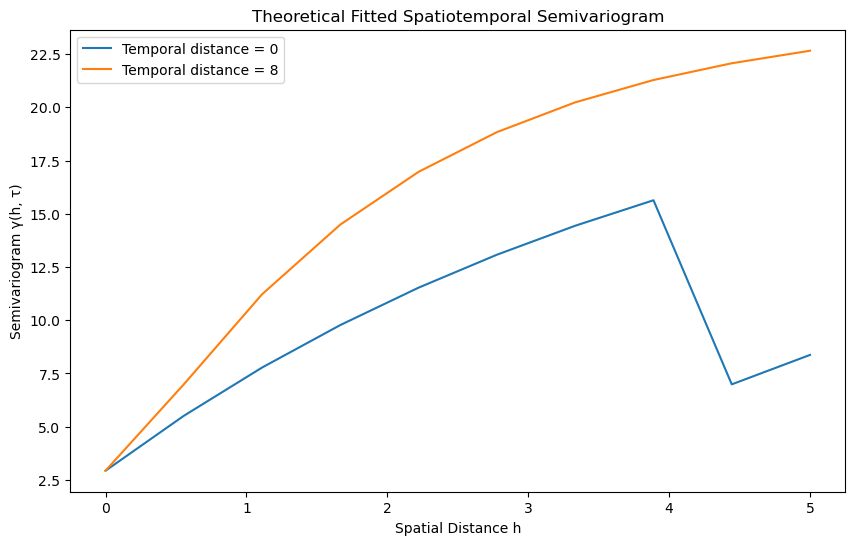

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def semivariogram(h, tau, params, covariance_function):
    # Create spatial and temporal distance arrays
    spatial_distances = np.linspace(0, h, 10)
    temporal_distances = np.linspace(1, tau ,8)
    
    # Compute the covariance at zero distance and zero time lag
    k_0_0 = covariance_function(params=params, y=torch.zeros((1, 4)), x=torch.zeros((1, 4)))[0, 0]
    
    # Compute the covariance at given distances
    h_t = np.array([[h, 0, 0,t] for h in spatial_distances for t in temporal_distances])
    k_h_tau = covariance_function(params=params, y=torch.zeros((len(h_t), 4)), x=torch.tensor(h_t, dtype=torch.float32))
    
    # Calculate the semivariogram
    gamma_h_tau = k_0_0 - k_h_tau.diag()
    
    return spatial_distances, temporal_distances, gamma_h_tau

# Example parameters
params = torch.tensor([24.42,1.92,1.92, -.045, .237, 3.34])

# Compute the semivariogram values
h = 5
tau = 8
spatial_distances, temporal_distances, gamma_h_tau = semivariogram(h, tau, params, matern_cov_yx2)
print(gamma_h_tau)
# Plot the semivariogram
plt.figure(figsize=(10, 6))
plt.plot(spatial_distances, gamma_h_tau[:10], label='Temporal distance = 0')
plt.plot(spatial_distances, gamma_h_tau[::8], label='Temporal distance = 8')
plt.xlabel('Spatial Distance h')
plt.ylabel('Semivariogram γ(h, τ)')
plt.title('Theoretical Fitted Spatiotemporal Semivariogram')
plt.legend()
plt.show()

In [27]:
def empirical_semivariogram(data, max_distance, num_bins):
    # Extract spatial and temporal coordinates and values
    lat = data[:, 0]
    lon = data[:, 1]
    ozone = data[:, 2]
    time = data[:, 3]

    # Calculate pairwise distances
    spatial_distances = np.sqrt((lat[:, None] - lat[None, :])**2 + (lon[:, None] - lon[None, :])**2)
    temporal_distances = np.abs(time[:, None] - time[None, :])
    
    # Calculate semivariances
    semivariances = 0.5 * (ozone[:, None] - ozone[None, :])**2

    # Bin the distances
    bins = np.linspace(0, max_distance, num_bins + 1)
    bin_indices = np.digitize(spatial_distances, bins) - 1

    # Calculate empirical semivariogram
    empirical_gamma = np.zeros(num_bins)
    for i in range(num_bins):
        mask = (bin_indices == i)
        if np.any(mask):
            empirical_gamma[i] = np.mean(semivariances[mask])

    return bins[:-1], empirical_gamma


# Compute the empirical semivariogram values
max_distance = 5
num_bins = 10
bins, empirical_gamma = empirical_semivariogram(aggregated_np, max_distance, num_bins)

# Plot the empirical semivariogram
plt.figure(figsize=(10, 6))
plt.plot(bins, empirical_gamma, 'o-', label='Empirical Semivariogram')
plt.xlabel('Spatial Distance h')
plt.ylabel('Semivariogram γ(h)')
plt.title('Empirical Semivariogram')
plt.legend()
plt.show()

/var/folders/9p/53hd4c7d2fl193h4jwp194wc0000gn/T/ipykernel_2132/3963131739.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  spatial_distances = np.sqrt((lat[:, None] - lat[None, :])**2 + (lon[:, None] - lon[None, :])**2)
/var/folders/9p/53hd4c7d2fl193h4jwp194wc0000gn/T/ipykernel_2132/3963131739.py:10: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  temporal_distances = np.abs(time[:, None] - time[None, :])


TypeError: mean() received an invalid combination of arguments - got (out=NoneType, dtype=NoneType, axis=NoneType, ), but expected one of:
 * (*, torch.dtype dtype = None)
 * (tuple of ints dim, bool keepdim = False, *, torch.dtype dtype = None)
 * (tuple of names dim, bool keepdim = False, *, torch.dtype dtype = None)
